<a href="https://colab.research.google.com/github/n25jinny/EnergyPlus/blob/22.1_low_flow_tol_fix/Sentiment_Analysis_with_ChatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
!pip install tqdm requests

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import openai
import requests
from tqdm import tqdm
import time

In [ ]:
# OpenAI API 키값 설정하기
openai.api_key = "INPUT YOUR API KEY" # "" 안에는 본인 계정 open api key 값을 넣어야 합니다.
GPT_API_URL = "https://api.openai.com/v1/chat/completions"

In [ ]:
# 데이터셋 가져오기
df =  pd.read_table('/content/drive/MyDrive/Colab_Notebooks/bab2min_corpus_master_sentiment_naver_shopping.txt', names=['Rating', 'Review Text'])

In [ ]:
df

,Rating,Review Text
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


긍/부정으로 분류하기 애매한 3점에 해당하는 텍스트들은 제외, 긍정(4 ~ 5점)과 부정(1 ~ 2점)의 비율이 1:1에 가깝도록 샘플링한 데이터셋

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Rating       200000 non-null  int64 
 1   Review Text  200000 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [ ]:
# 윗쪽 200개 데이터만 사용
df = df.iloc[0:200]

In [ ]:
df

,Rating,Review Text
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
195,5,기대한만큼 좋은소금.
196,2,색상이조금아쉬워요베이지
197,5,이시기에 배송도 빠르고 좋은것 같아요~
198,1,재구매 불량품이 너무 많아요 매번 주문했었는데 이번에는 실망스러워요 테이프가 끊어지...


In [ ]:
df['Rating'].value_counts(normalize=True).sort_index()

1    0.16
2    0.32
4    0.09
5    0.43
Name: Rating, dtype: float64

In [ ]:
# 띄어쓰기 기준으로 리뷰 길이 체크
review_list = []

for review in df['Review Text']:
  split= review.split()
  review_list.append(split)

리뷰의 최대 단어 수 : 27
리뷰의 평균 단어 수 : 7.705


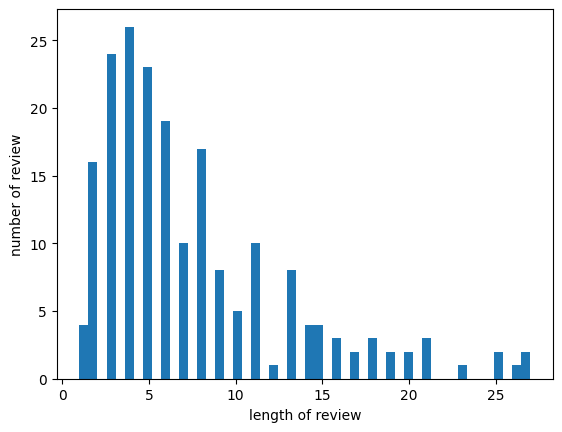

In [ ]:
print('리뷰의 최대 단어 수 :', max(len(review) for review in review_list))
print('리뷰의 평균 단어 수 :', sum(map(len, review_list))/len(review_list))
plt.hist([len(review) for review in review_list], bins=50)
plt.xlabel('length of review')
plt.ylabel('number of review')
plt.show()

In [ ]:
## ChatGPT API를 활용한 감정분석

# 리뷰를 분석하기 위한 함수 작성
def analyze_review(review):

  try:
    messages = [
            {"role": "system", "content": "너는 제품 리뷰에 담긴 고객 감정을 분석하고 탐지하는 AI 언어모델이야"},
            {"role": "user", "content": f"다음 제품 리뷰를 분석해 고객 감정이 긍정인지 부정인지 판단해 알려줘. 대답은 다른 추가적인 설명없이 '긍정' 또는 '부정'  둘 중 하나의 단어로 대답해야 해: {review}"}
        ]

    completion = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=messages,
            max_tokens=3,
            n=1,
            stop=None,
            temperature=0
        )

    response= completion.choices[0].message.content
    print(response)
    return response

  except openai.error.RateLimitError as e:
    retry_time = e.retry_after if hasattr(e, 'retry_after') else 30
    print(f"Rate limit exceeded. Retrying in {retry_time} seconds...")
    time.sleep(retry_time)
    return analyze_review(review)

  except openai.error.ServiceUnavailableError as e:
    retry_time = 10  # Adjust the retry time as needed
    print(f"Service is unavailable. Retrying in {retry_time} seconds...")
    time.sleep(retry_time)
    return analyze_review(review)

  except openai.error.APIError as e:
    retry_time = e.retry_after if hasattr(e, 'retry_after') else 30
    print(f"API error occurred. Retrying in {retry_time} seconds...")
    time.sleep(retry_time)
    return analyze_review(review)

# 리뷰 분석해 저장하기
sentiments = []

for review in tqdm(df["Review Text"]):
    sentiment = analyze_review(review)
    sentiments.append(sentiment)

df["Sentiment"] = sentiments

# 엑셀파일로 출력하기
df.to_excel('/content/drive/MyDrive/Colab_Notebooks/reviews_analyzed_sentiment.xlsx', index=False)

  0%|          | 1/200 [00:00<01:59,  1.66it/s]

긍정


  1%|          | 2/200 [00:01<02:02,  1.62it/s]

부정


  2%|▏         | 3/200 [00:01<01:54,  1.72it/s]

긍정


  2%|▏         | 4/200 [00:02<02:16,  1.44it/s]

부정


  2%|▎         | 5/200 [00:03<01:52,  1.74it/s]

긍정


  3%|▎         | 6/200 [00:03<02:06,  1.53it/s]

부정


  4%|▎         | 7/200 [00:04<02:16,  1.41it/s]

부정


  4%|▍         | 8/200 [00:05<02:14,  1.43it/s]

부정


  4%|▍         | 9/200 [00:05<02:07,  1.50it/s]

부정


  5%|▌         | 10/200 [00:06<01:43,  1.83it/s]

부정


  6%|▌         | 11/200 [00:06<01:31,  2.06it/s]

긍정


  6%|▌         | 12/200 [00:07<01:38,  1.91it/s]

부정


  6%|▋         | 13/200 [00:12<05:53,  1.89s/it]

부정


  7%|▋         | 14/200 [00:12<04:46,  1.54s/it]

부정


  8%|▊         | 15/200 [00:13<03:38,  1.18s/it]

긍정


  8%|▊         | 16/200 [00:18<07:42,  2.51s/it]

긍정


  8%|▊         | 17/200 [00:19<06:08,  2.01s/it]

긍정


  9%|▉         | 18/200 [00:19<04:31,  1.49s/it]

부정


 10%|▉         | 19/200 [00:20<04:01,  1.33s/it]

부정


 10%|█         | 20/200 [00:21<03:24,  1.14s/it]

긍정


 10%|█         | 21/200 [00:21<02:37,  1.13it/s]

긍정


 11%|█         | 22/200 [00:23<03:01,  1.02s/it]

부정


 12%|█▏        | 23/200 [00:23<02:26,  1.21it/s]

긍정


 12%|█▏        | 24/200 [00:24<02:17,  1.28it/s]

부정


 12%|█▎        | 25/200 [00:25<02:15,  1.29it/s]

긍정


 13%|█▎        | 26/200 [00:25<02:13,  1.30it/s]

부정


 14%|█▎        | 27/200 [00:26<02:09,  1.33it/s]

부정


 14%|█▍        | 28/200 [00:27<02:16,  1.26it/s]

부정


 14%|█▍        | 29/200 [00:27<01:48,  1.58it/s]

부정


 15%|█▌        | 30/200 [00:28<02:04,  1.37it/s]

부정


 16%|█▌        | 31/200 [00:29<01:45,  1.60it/s]

부정


 16%|█▌        | 32/200 [00:29<01:51,  1.51it/s]

부정


 16%|█▋        | 33/200 [00:30<01:45,  1.59it/s]

부정


 17%|█▋        | 34/200 [00:30<01:29,  1.86it/s]

긍정


 18%|█▊        | 35/200 [00:30<01:17,  2.12it/s]

긍정


 18%|█▊        | 36/200 [00:31<01:32,  1.77it/s]

부정


 18%|█▊        | 37/200 [00:32<01:52,  1.45it/s]

부정


 19%|█▉        | 38/200 [00:33<01:35,  1.70it/s]

긍정


 20%|█▉        | 39/200 [00:34<01:54,  1.40it/s]

부정


 20%|██        | 40/200 [00:34<01:59,  1.34it/s]

부정


 20%|██        | 41/200 [00:35<01:36,  1.65it/s]

긍정


 21%|██        | 42/200 [00:35<01:20,  1.95it/s]

부정


 22%|██▏       | 43/200 [00:35<01:14,  2.10it/s]

긍정


 22%|██▏       | 44/200 [00:36<01:09,  2.24it/s]

긍정


 22%|██▎       | 45/200 [00:36<01:13,  2.11it/s]

긍정


 23%|██▎       | 46/200 [00:37<01:26,  1.78it/s]

부정


 24%|██▎       | 47/200 [00:37<01:18,  1.94it/s]

부정


 24%|██▍       | 48/200 [00:38<01:07,  2.24it/s]

부정


 24%|██▍       | 49/200 [00:38<01:19,  1.90it/s]

부정


 25%|██▌       | 50/200 [00:39<01:07,  2.24it/s]

긍정


 26%|██▌       | 51/200 [00:39<00:59,  2.49it/s]

긍정


 26%|██▌       | 52/200 [00:39<00:58,  2.54it/s]

부정


 26%|██▋       | 53/200 [00:40<01:10,  2.09it/s]

부정


 27%|██▋       | 54/200 [00:41<01:21,  1.80it/s]

부정


 28%|██▊       | 55/200 [00:41<01:09,  2.08it/s]

부정


 28%|██▊       | 56/200 [00:41<01:03,  2.28it/s]

부정


 28%|██▊       | 57/200 [00:43<01:39,  1.43it/s]

부정


 29%|██▉       | 58/200 [00:43<01:24,  1.69it/s]

긍정


 30%|██▉       | 59/200 [00:43<01:09,  2.02it/s]

긍정


 30%|███       | 60/200 [00:44<01:16,  1.84it/s]

긍정


 30%|███       | 61/200 [00:44<01:04,  2.14it/s]

긍정


 31%|███       | 62/200 [00:45<00:59,  2.31it/s]

부정


 32%|███▏      | 63/200 [00:45<00:55,  2.45it/s]

긍정


 32%|███▏      | 64/200 [00:45<00:53,  2.52it/s]

긍정


 32%|███▎      | 65/200 [00:46<00:51,  2.62it/s]

긍정


 33%|███▎      | 66/200 [00:46<00:46,  2.85it/s]

긍정


 34%|███▎      | 67/200 [00:46<00:44,  2.97it/s]

긍정


 34%|███▍      | 68/200 [00:47<00:42,  3.12it/s]

긍정


 34%|███▍      | 69/200 [00:47<00:40,  3.25it/s]

부정


 35%|███▌      | 70/200 [00:47<00:40,  3.25it/s]

부정


 36%|███▌      | 71/200 [00:48<01:08,  1.89it/s]

"이 제


 36%|███▌      | 72/200 [00:49<01:12,  1.77it/s]

부정


 36%|███▋      | 73/200 [00:49<01:00,  2.10it/s]

긍정


 37%|███▋      | 74/200 [00:49<00:54,  2.29it/s]

긍정


 38%|███▊      | 75/200 [00:50<00:50,  2.49it/s]

부정


 38%|███▊      | 76/200 [00:50<00:48,  2.56it/s]

긍정


 38%|███▊      | 77/200 [00:50<00:44,  2.76it/s]

긍정


 39%|███▉      | 78/200 [00:51<00:41,  2.95it/s]

부정


 40%|███▉      | 79/200 [00:54<02:42,  1.34s/it]

긍정


 40%|████      | 80/200 [00:55<02:03,  1.03s/it]

긍정


 40%|████      | 81/200 [00:55<01:38,  1.21it/s]

긍정


 41%|████      | 82/200 [00:55<01:18,  1.51it/s]

긍정


 42%|████▏     | 83/200 [00:56<01:02,  1.89it/s]

부정


 42%|████▏     | 84/200 [00:56<00:53,  2.18it/s]

긍정


 42%|████▎     | 85/200 [01:16<11:59,  6.26s/it]

부정


 43%|████▎     | 86/200 [01:16<08:30,  4.47s/it]

긍정


 44%|████▎     | 87/200 [01:16<06:03,  3.22s/it]

부정


 44%|████▍     | 88/200 [01:17<04:36,  2.47s/it]

부정


 44%|████▍     | 89/200 [01:17<03:25,  1.85s/it]

긍정


 45%|████▌     | 90/200 [01:18<02:33,  1.40s/it]

긍정


 46%|████▌     | 91/200 [01:18<01:58,  1.09s/it]

부정


 46%|████▌     | 92/200 [01:18<01:31,  1.18it/s]

긍정


 46%|████▋     | 93/200 [01:19<01:19,  1.34it/s]

긍정


 47%|████▋     | 94/200 [01:19<01:13,  1.45it/s]

긍정


 48%|████▊     | 95/200 [01:20<01:02,  1.67it/s]

긍정


 48%|████▊     | 96/200 [01:20<00:52,  1.97it/s]

긍정


 48%|████▊     | 97/200 [01:21<00:47,  2.17it/s]

부정


 49%|████▉     | 98/200 [01:21<00:58,  1.76it/s]

긍정


 50%|████▉     | 99/200 [01:22<00:55,  1.81it/s]

긍정


 50%|█████     | 100/200 [01:22<00:49,  2.01it/s]

부정


 50%|█████     | 101/200 [01:23<00:44,  2.24it/s]

부정


 51%|█████     | 102/200 [01:23<00:38,  2.53it/s]

부정


 52%|█████▏    | 103/200 [01:32<04:44,  2.93s/it]

긍정


 52%|█████▏    | 104/200 [01:32<03:24,  2.13s/it]

부정
Service is unavailable. Retrying in 10 seconds...


 52%|█████▎    | 105/200 [02:13<21:44, 13.73s/it]

긍정


 53%|█████▎    | 106/200 [02:13<15:10,  9.69s/it]

긍정


 54%|█████▎    | 107/200 [02:13<10:40,  6.89s/it]

부정


 54%|█████▍    | 108/200 [02:14<07:34,  4.94s/it]

긍정


 55%|█████▍    | 109/200 [02:14<05:28,  3.61s/it]

부정


 55%|█████▌    | 110/200 [02:15<04:10,  2.78s/it]

부정


 56%|█████▌    | 111/200 [02:15<03:02,  2.05s/it]

긍정


 56%|█████▌    | 112/200 [02:16<02:24,  1.64s/it]

긍정


 56%|█████▋    | 113/200 [02:17<01:52,  1.30s/it]

긍정


 57%|█████▋    | 114/200 [02:17<01:26,  1.00s/it]

죄


 57%|█████▊    | 115/200 [02:17<01:06,  1.27it/s]

부정


 58%|█████▊    | 116/200 [02:19<01:25,  1.01s/it]

긍정


 58%|█████▊    | 117/200 [02:19<01:08,  1.22it/s]

긍정


 59%|█████▉    | 118/200 [02:20<01:16,  1.07it/s]

긍정


 60%|█████▉    | 119/200 [02:21<01:04,  1.25it/s]

긍정


 60%|██████    | 120/200 [02:22<01:03,  1.26it/s]

긍정


 60%|██████    | 121/200 [02:22<00:52,  1.52it/s]

긍정


 61%|██████    | 122/200 [02:23<00:54,  1.44it/s]

부정


 62%|██████▏   | 123/200 [02:24<00:57,  1.34it/s]

부정


 62%|██████▏   | 124/200 [02:24<00:45,  1.67it/s]

긍정


 62%|██████▎   | 125/200 [02:25<00:50,  1.48it/s]

부정


 63%|██████▎   | 126/200 [02:25<00:47,  1.54it/s]

부정


 64%|██████▎   | 127/200 [02:26<00:39,  1.85it/s]

긍정


 64%|██████▍   | 128/200 [02:26<00:35,  2.02it/s]

부정


 64%|██████▍   | 129/200 [02:26<00:29,  2.37it/s]

부정


 65%|██████▌   | 130/200 [02:26<00:25,  2.73it/s]

긍정


 66%|██████▌   | 131/200 [02:27<00:25,  2.72it/s]

부정


 66%|██████▌   | 132/200 [02:27<00:25,  2.65it/s]

부정


 66%|██████▋   | 133/200 [02:27<00:23,  2.82it/s]

긍정


 67%|██████▋   | 134/200 [02:29<00:36,  1.81it/s]

부정


 68%|██████▊   | 135/200 [02:29<00:29,  2.18it/s]

긍정


 68%|██████▊   | 136/200 [02:29<00:27,  2.36it/s]

부정


 68%|██████▊   | 137/200 [02:29<00:24,  2.61it/s]

부정


 69%|██████▉   | 138/200 [02:30<00:22,  2.72it/s]

부정


 70%|██████▉   | 139/200 [02:30<00:21,  2.89it/s]

긍정


 70%|███████   | 140/200 [02:30<00:19,  3.05it/s]

긍정


 70%|███████   | 141/200 [02:31<00:21,  2.77it/s]

긍정


 71%|███████   | 142/200 [02:32<00:30,  1.88it/s]

부정


 72%|███████▏  | 143/200 [02:33<00:52,  1.08it/s]

부정


 72%|███████▏  | 144/200 [02:34<00:40,  1.39it/s]

부정


 72%|███████▎  | 145/200 [02:34<00:33,  1.62it/s]

긍정


 73%|███████▎  | 146/200 [02:34<00:28,  1.88it/s]

부정


 74%|███████▎  | 147/200 [02:35<00:33,  1.58it/s]

긍정


 74%|███████▍  | 148/200 [02:36<00:27,  1.87it/s]

긍정


 74%|███████▍  | 149/200 [02:36<00:23,  2.15it/s]

부정


 75%|███████▌  | 150/200 [02:36<00:21,  2.37it/s]

긍정


 76%|███████▌  | 151/200 [02:36<00:17,  2.76it/s]

부정


 76%|███████▌  | 152/200 [02:37<00:16,  2.91it/s]

부정


 76%|███████▋  | 153/200 [02:37<00:15,  3.07it/s]

부정


 77%|███████▋  | 154/200 [02:39<00:34,  1.34it/s]

부정


 78%|███████▊  | 155/200 [02:39<00:27,  1.63it/s]

긍정


 78%|███████▊  | 156/200 [02:39<00:23,  1.87it/s]

긍정


 78%|███████▊  | 157/200 [02:40<00:20,  2.08it/s]

부정


 79%|███████▉  | 158/200 [02:41<00:23,  1.79it/s]

부정


 80%|███████▉  | 159/200 [02:41<00:20,  2.05it/s]

긍정


 80%|████████  | 160/200 [02:41<00:19,  2.03it/s]

부정


 80%|████████  | 161/200 [02:42<00:16,  2.31it/s]

첫 번


 81%|████████  | 162/200 [02:42<00:15,  2.40it/s]

긍정


 82%|████████▏ | 163/200 [02:42<00:13,  2.65it/s]

긍정


 82%|████████▏ | 164/200 [02:43<00:13,  2.64it/s]

부정


 82%|████████▎ | 165/200 [02:43<00:12,  2.69it/s]

부정


 83%|████████▎ | 166/200 [02:44<00:17,  1.96it/s]

부정


 84%|████████▎ | 167/200 [02:44<00:17,  1.93it/s]

긍정


 84%|████████▍ | 168/200 [02:45<00:14,  2.15it/s]

부정


 84%|████████▍ | 169/200 [02:45<00:14,  2.13it/s]

부정


 85%|████████▌ | 170/200 [02:46<00:20,  1.46it/s]

긍정


 86%|████████▌ | 171/200 [02:47<00:16,  1.73it/s]

부정


 86%|████████▌ | 172/200 [02:47<00:17,  1.61it/s]

긍정


 86%|████████▋ | 173/200 [02:48<00:14,  1.84it/s]

긍정


 87%|████████▋ | 174/200 [02:48<00:12,  2.10it/s]

긍정


 88%|████████▊ | 175/200 [02:49<00:12,  1.99it/s]

긍정


 88%|████████▊ | 176/200 [02:49<00:10,  2.27it/s]

부정


 88%|████████▊ | 177/200 [02:50<00:11,  1.97it/s]

긍정


 89%|████████▉ | 178/200 [02:50<00:12,  1.78it/s]

부정


 90%|████████▉ | 179/200 [02:51<00:10,  2.09it/s]

긍정


 90%|█████████ | 180/200 [02:51<00:08,  2.31it/s]

긍정


 90%|█████████ | 181/200 [02:51<00:08,  2.33it/s]

부정


 91%|█████████ | 182/200 [02:52<00:08,  2.08it/s]

긍정


 92%|█████████▏| 183/200 [02:53<00:09,  1.86it/s]

긍정


 92%|█████████▏| 184/200 [02:53<00:07,  2.16it/s]

부정


 92%|█████████▎| 185/200 [02:53<00:06,  2.41it/s]

부정


 93%|█████████▎| 186/200 [02:54<00:05,  2.51it/s]

부정


 94%|█████████▎| 187/200 [02:54<00:05,  2.28it/s]

부정


 94%|█████████▍| 188/200 [02:55<00:08,  1.43it/s]

긍정


 94%|█████████▍| 189/200 [02:56<00:08,  1.31it/s]

긍정


 95%|█████████▌| 190/200 [02:57<00:06,  1.62it/s]

긍정


 96%|█████████▌| 191/200 [02:57<00:04,  1.86it/s]

긍정


 96%|█████████▌| 192/200 [02:58<00:04,  1.84it/s]

긍정


 96%|█████████▋| 193/200 [02:58<00:03,  1.81it/s]

긍정


 97%|█████████▋| 194/200 [02:59<00:02,  2.01it/s]

긍정


 98%|█████████▊| 195/200 [02:59<00:02,  1.85it/s]

부정


 98%|█████████▊| 196/200 [03:00<00:02,  1.95it/s]

긍정


 98%|█████████▊| 197/200 [03:00<00:01,  2.16it/s]

부정


 99%|█████████▉| 198/200 [03:03<00:02,  1.27s/it]

긍정


100%|█████████▉| 199/200 [03:04<00:01,  1.21s/it]

부정


100%|██████████| 200/200 [03:04<00:00,  1.08it/s]

부정



<ipython-input-14-ad657c4a8a2e>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sentiment"] = sentiments


In [ ]:
df

,Rating,Review Text,Sentiment
0,5,배공빠르고 굿,긍정
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,부정
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,긍정
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,부정
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,긍정
...,...,...,...
195,5,기대한만큼 좋은소금.,긍정
196,2,색상이조금아쉬워요베이지,부정
197,5,이시기에 배송도 빠르고 좋은것 같아요~,긍정
198,1,재구매 불량품이 너무 많아요 매번 주문했었는데 이번에는 실망스러워요 테이프가 끊어지...,부정


In [ ]:
print('긍정 & Rating 4~5점:', len(df[(df['Sentiment']=='긍정') & ((df['Rating']==4) | (df['Rating']==5))]))
print('긍정 & Rating 1~2점:', len(df[(df['Sentiment']=='긍정') & ((df['Rating']==1) | (df['Rating']==2))]))
print('부정 & Rating 4~5점:', len(df[(df['Sentiment']=='부정') & ((df['Rating']==4) | (df['Rating']==5))]))
print('부정 & Rating 1~2점:', len(df[(df['Sentiment']=='부정') & ((df['Rating']==1) | (df['Rating']==2))]))

긍정 & Rating 4~5점: 93
긍정 & Rating 1~2점: 6
부정 & Rating 4~5점: 10
부정 & Rating 1~2점: 88


평점이 4점과 5점인데 ChatGPT가 '부정'으로 잘못 분류한 경우는 6개, 1점과 2점인데 '긍정'으로 잘못 분류한 경우는 10개로 197개 데이터 가운데 16개를 잘못 분류함(약 91% 정확도, 3개 데이터의 경우 긍정 부정이 아닌 다른 단어로 출력)

In [ ]:
## ChatGPT API를 활용해 긍정/부정 단어 추출하기

def generate_proscons_list(review):

    try:
      messages = [
        {"role": "system", "content": "너는 제품 리뷰를 기반으로 제품과 관련된 긍정 단어와 부정 단어를 추출하는 AI 언어 모델이야"},
        {"role": "user", "content": f"다음 제품 리뷰에서 제품을 평가하는 긍정 단어, 부정 단어를 추출해줘.  다른 추가적인 설명없이 긍정 단어, 부정 단어만 각각 작성해줘: {review}"}
      ]

      completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=100,
        n=1,
        stop=None,
        temperature=0
      )

      response = completion.choices[0].message.content
      return response

    except openai.error.RateLimitError as e:
      retry_time = e.retry_after if hasattr(e, 'retry_after') else 30
      print(f"Rate limit exceeded. Retrying in {retry_time} seconds...")
      time.sleep(retry_time)
      return generate_proscons_list(review)

    except openai.error.ServiceUnavailableError as e:
      retry_time = 10  # Adjust the retry time as needed
      print(f"Service is unavailable. Retrying in {retry_time} seconds...")
      time.sleep(retry_time)
      return generate_proscons_list(review)

    except openai.error.APIError as e:
      retry_time = e.retry_after if hasattr(e, 'retry_after') else 30
      print(f"API error occurred. Retrying in {retry_time} seconds...")
      time.sleep(retry_time)
      return generate_proscons_list(review)

# Analyze the reviews and store the results
procons = []

for review in tqdm(df["Review Text"]):
    procon = generate_proscons_list(review)
    procons.append(procon)

df["Procons"] = procons

# Save the results to a new excel file
df.to_excel('/content/drive/MyDrive/Colab_Notebooks/reviews_analyzed_proscons.xlsx', index=False)

 38%|███▊      | 76/200 [02:19<02:39,  1.29s/it]

API error occurred. Retrying in 30 seconds...


 75%|███████▌  | 150/200 [10:27<01:30,  1.82s/it]

API error occurred. Retrying in 30 seconds...


100%|██████████| 200/200 [17:42<00:00,  5.31s/it]
<ipython-input-17-e29aaa484d18>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Procons"] = procons


In [ ]:
df['Procons'][0]

'긍정 단어: 배송 빠름, 좋음\n부정 단어: 없음'

In [ ]:
## ChatGPT API를 활용해 제품 개선안 도출하기

def generate_improvement_suggestions(review):

    try:
        messages = [
            {"role": "system", "content": "너는 제품 리뷰를 분석해 제품 개선안을 제안하는 AI 언어모델이야"},
            {"role": "user", "content": f"다음 제품 리뷰를 기반으로 3가지 제품 개선안을 제안해 줘. 다른 추가적인 설명없이 3가지 개선사항만 작성해줘: {review}"}
        ]

        completion = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=messages,
            max_tokens=500,
            n=1,
            stop=None,
            temperature=0.7
        )

        response = completion.choices[0].message.content
        return response

    except openai.error.RateLimitError as e:
      retry_time = e.retry_after if hasattr(e, 'retry_after') else 30
      print(f"Rate limit exceeded. Retrying in {retry_time} seconds...")
      time.sleep(retry_time)
      return generate_proscons_list(review)

    except openai.error.ServiceUnavailableError as e:
      retry_time = 10  # Adjust the retry time as needed
      print(f"Service is unavailable. Retrying in {retry_time} seconds...")
      time.sleep(retry_time)
      return generate_proscons_list(review)

    except openai.error.APIError as e:
      retry_time = e.retry_after if hasattr(e, 'retry_after') else 30
      print(f"API error occurred. Retrying in {retry_time} seconds...")
      time.sleep(retry_time)
      return generate_proscons_list(review)


# Analyze the reviews and store the results
sugguestions = []

for review in tqdm(df["Review Text"]):
    sugguestion = generate_improvement_suggestions(review)
    sugguestions.append(sugguestion)

df["Sugguestions"] = sugguestions

# Save the results to a new excel file
df.to_excel('/content/drive/MyDrive/Colab_Notebooks/reviews_analyzed_sugguestions.xlsx', index=False)

 72%|███████▏  | 144/200 [35:25<14:59, 16.06s/it]

API error occurred. Retrying in 30 seconds...


100%|██████████| 200/200 [55:05<00:00, 16.53s/it]
<ipython-input-19-1c842594c4ba>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sugguestions"] = sugguestions
